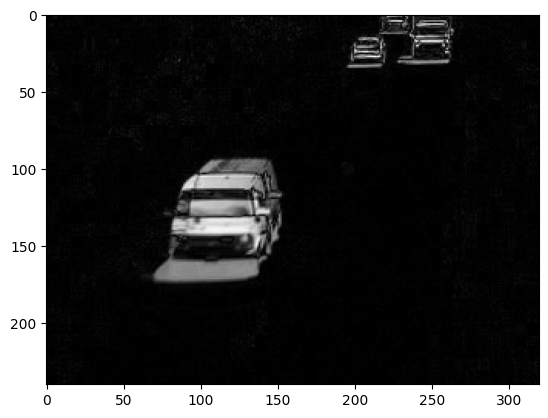

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

PATH = 'Materials'

I = cv2.imread(f'{PATH}/I.jpg', cv2.IMREAD_GRAYSCALE)  # noqa: E741
J = cv2.imread(f'{PATH}/J.jpg', cv2.IMREAD_GRAYSCALE)
diff = cv2.absdiff(I, J)
plt.imshow(diff, cmap='gray')

### Metoda blokowa

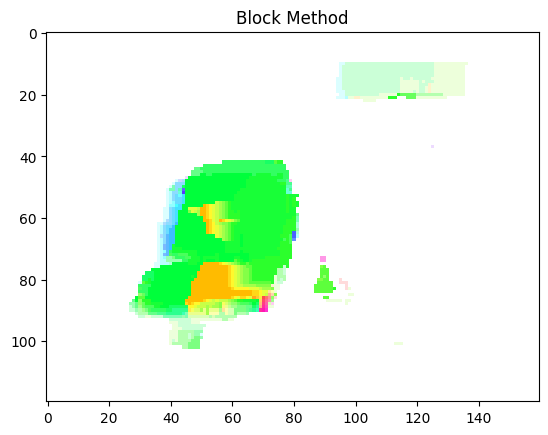

In [ ]:
def block_method(N=11, I=None, J=None): # noqa: E741
    W2 = N // 2
    dX, dY = W2, W2
    if I is None:
        I = cv2.imread(f'{PATH}/I.jpg', cv2.IMREAD_GRAYSCALE)  # noqa: E741
    if J is None:
        J = cv2.imread(f'{PATH}/J.jpg', cv2.IMREAD_GRAYSCALE)
    I = cv2.resize(I, (I.shape[1]//2, I.shape[0]//2))  # noqa: E741
    J = cv2.resize(J, (J.shape[1]//2, J.shape[0]//2))
    u = np.zeros(I.shape[:2])
    v = np.zeros(I.shape[:2])

    for y in range(W2*2, I.shape[0] - W2*2):
        for x in range(W2*2, I.shape[1] - W2*2):
            IO = np.float32(I[y - W2:y + W2 + 1, x - W2:x + W2 + 1])
            lowest_diff = float('inf')
            for j in range(-dY, dY + 1):
                for i in range(-dX, dX + 1):
                    JO = np.float32(J[y + j - W2:y + j + W2 + 1, x + i - W2:x + i + W2 + 1])
                    diff = np.sqrt(np.sum(np.square(JO - IO)))
                    if lowest_diff > diff:
                        lowest_diff = diff
                        u[y, x] = i
                        v[y, x] = j

    magnitude, angle = cv2.cartToPolar(u, v)
    hsv_image = np.zeros((I.shape[0], I.shape[1], 3), dtype=np.uint8)
    hsv_image[..., 0] = angle * 90 / np.pi
    hsv_image[..., 1] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    hsv_image[..., 2] = 255
    img = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

    plt.imshow(img)
    plt.title('Block Method')
    plt.show()

block_method()

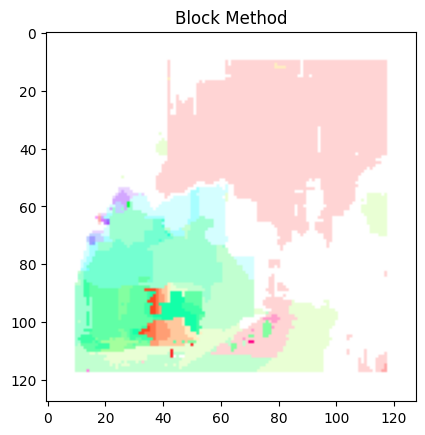

In [3]:
block_method(I=cv2.imread(f'{PATH}/cm1.png'), J=cv2.imread(f'{PATH}/cm2.png'))

### Wieloskalowa wersja metody blokowej

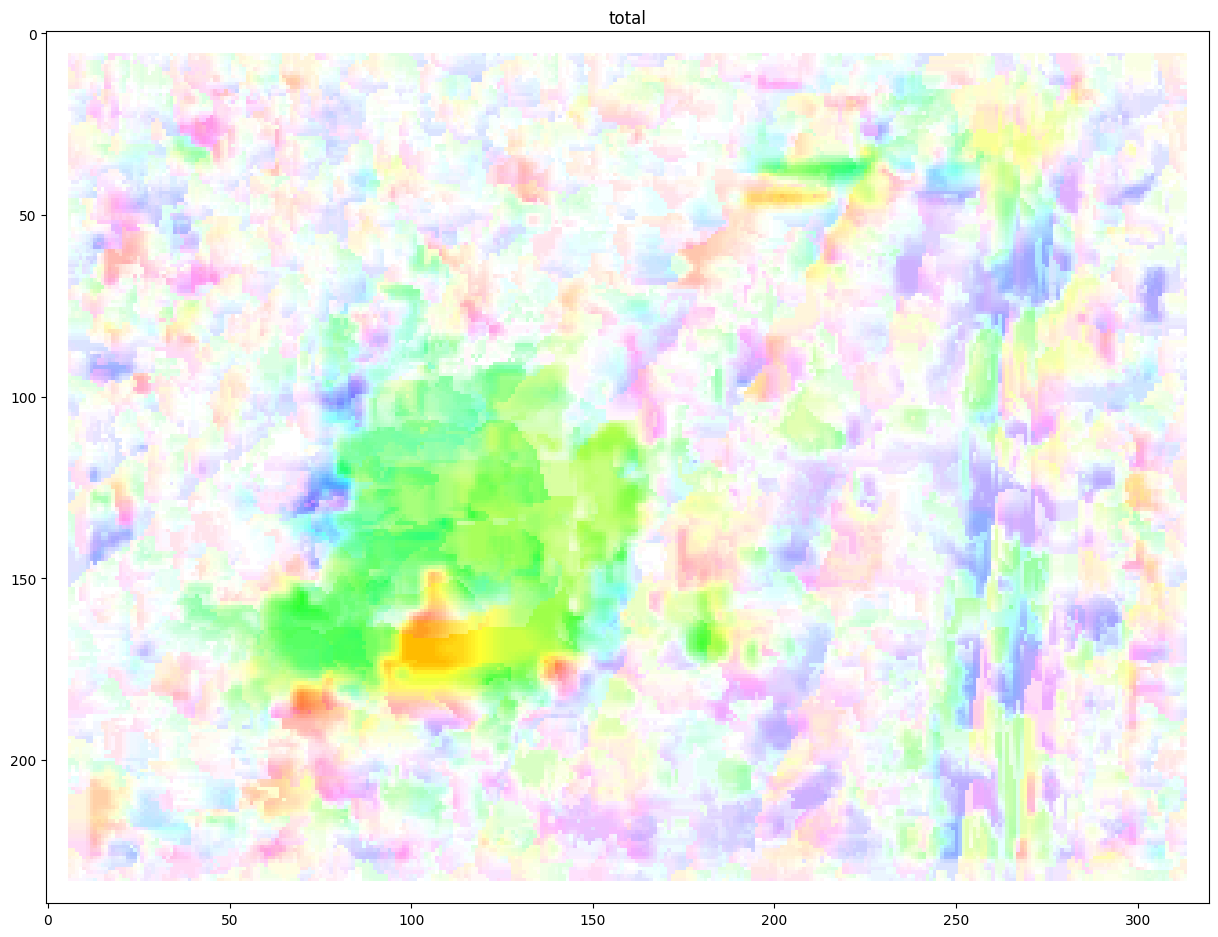

In [4]:
def of(I_org, I, J, W2=3, dY=3, dX=3): # noqa: E741
    J = cv2.resize(J, (I.shape[1], I.shape[0]))
    u = np.zeros(I.shape[:2])
    v = np.zeros(I.shape[:2])

    for y in range(W2*2, I.shape[0] - W2*2):
        for x in range(W2*2, I.shape[1] - W2*2):
            IO = np.float32(I[y - W2:y + W2 + 1, x - W2:x + W2 + 1])
            lowest_diff = float('inf')
            for j in range(-dY, dY + 1):
                for i in range(-dX, dX + 1):
                    JO = np.float32(J[y + j - W2:y + j + W2 + 1, x + i - W2:x + i + W2 + 1])
                    diff = np.sqrt(np.sum(np.square(JO - IO)))
                    if lowest_diff > diff:
                        lowest_diff = diff
                        u[y, x] = i
                        v[y, x] = j

    return u, v



def vis_flow(u, v, YX, name):
    magnitude, angle = cv2.cartToPolar(u, v)
    hsv_image = np.zeros((YX[0], YX[1], 3), dtype=np.uint8)
    hsv_image[..., 0] = angle * 90 / np.pi
    hsv_image[..., 1] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    hsv_image[..., 2] = 255
    img = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    plt.figure(figsize=(15, 15))

    plt.title(name)
    plt.imshow(img)
    plt.show()


def pyramid(im, max_scale):
    images =[]
    for k in range(max_scale, 0, -1):
        images.append(cv2.resize(im, (0,0), fx=(0.5)**k, fy=(0.5)**k))
    images.append(im)
    return images

def of_multiscale(max_scale=2, I_org=None, J=None):
    if I_org is None:
        I_org = cv2.imread(f'{PATH}/I.jpg', cv2.IMREAD_GRAYSCALE)  # noqa: E741
    if J is None:
        J = cv2.imread(f'{PATH}/J.jpg', cv2.IMREAD_GRAYSCALE)

    IP = pyramid(I_org, max_scale)
    I = IP[0] # noqa: E741
    total_u = np.zeros(I_org.shape[:2])
    total_v = np.zeros(I_org.shape[:2])


    for k in range(max_scale, -1, -1):
        u, v = of(I_org, I, J)
        h, w = I.shape[:2]

        y_indices, x_indices = np.indices((h, w))

        map_x = (x_indices + v).astype(np.float32)
        map_y = (y_indices + u).astype(np.float32)

        I_new = cv2.remap(I, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        I = cv2.resize(I_new, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR) # noqa: E741
        u = u*2**k
        v = v*2**k
        total_u += cv2.resize(u, (0, 0), fx=2**k, fy=2**k, interpolation=cv2.INTER_LINEAR)
        total_v += cv2.resize(v, (0, 0), fx=2**k, fy=2**k, interpolation=cv2.INTER_LINEAR)
    vis_flow(total_u, total_v, I_org.shape, 'total')

of_multiscale()

### compare methods

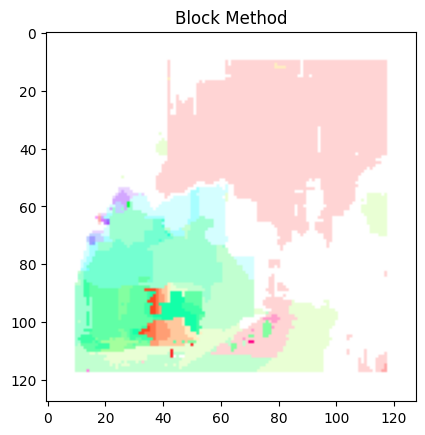

CPU times: user 8.12 s, sys: 76.4 ms, total: 8.2 s
Wall time: 8.52 s


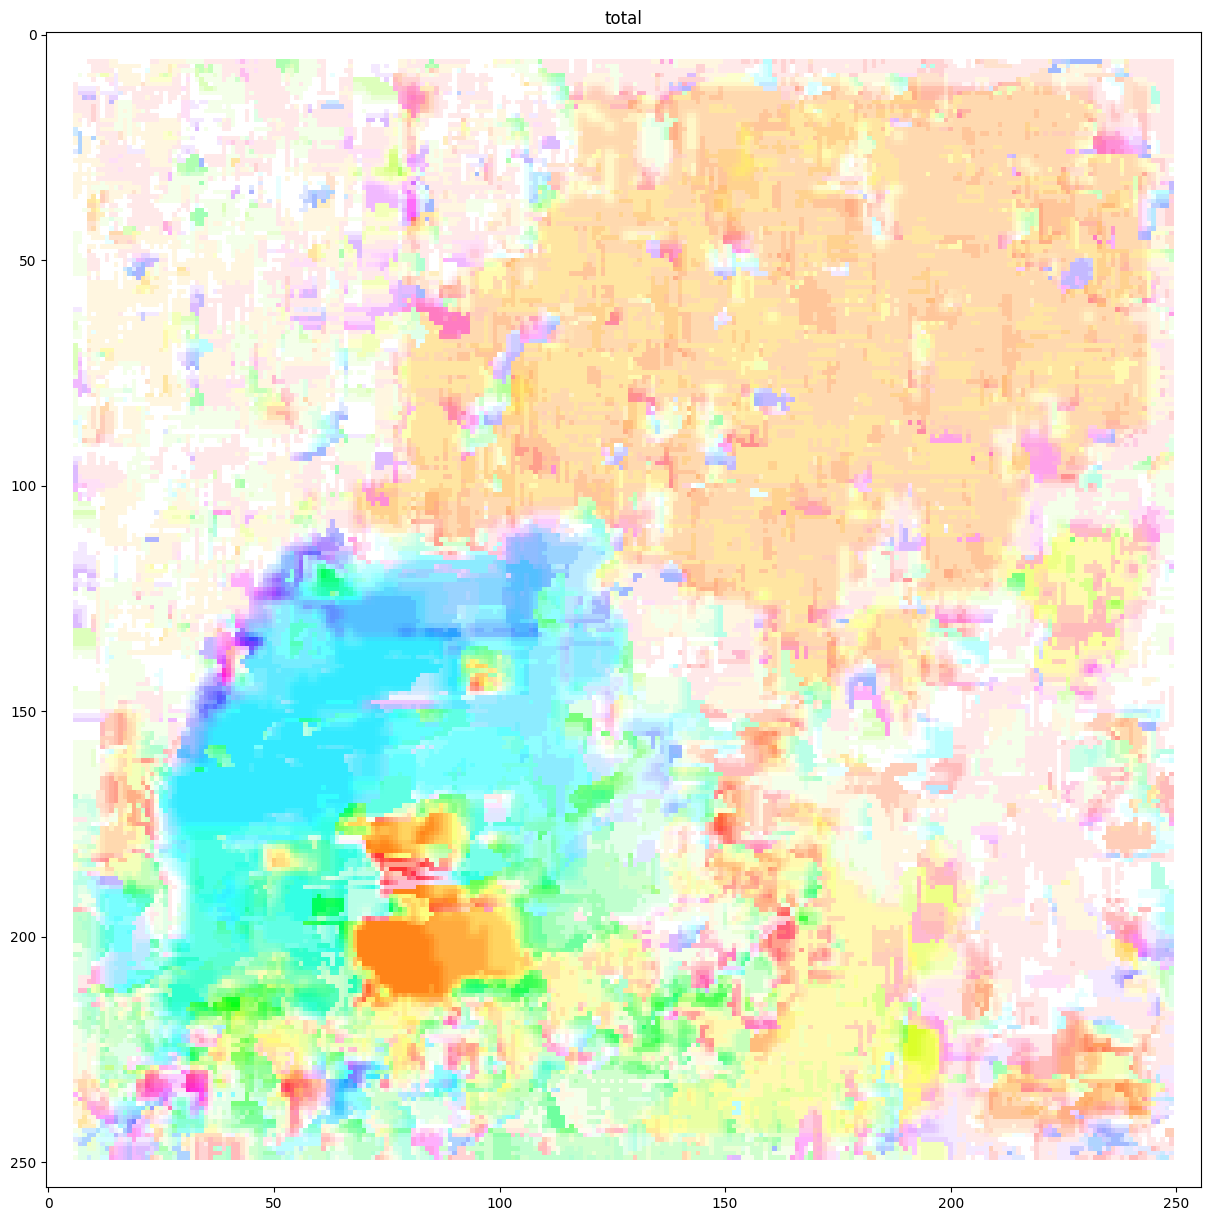

CPU times: user 19.5 s, sys: 218 ms, total: 19.7 s
Wall time: 20.3 s


In [5]:
I = cv2.imread(f'{PATH}/cm1.png')  # noqa: E741
J = cv2.imread(f'{PATH}/cm2.png')
%time block_method(N=11, I=I, J=J)

%time of_multiscale(max_scale=1, I_org=I, J=J)